In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary

In [3]:
from torch.nn.modules.normalization import LocalResponseNorm
from torch.nn.modules.activation import ReLU
from torch.nn.modules.pooling import MaxPool2d
class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        # super(AlexNet, self).__init__() python2 version 에서 사용되던 방식
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # fc layer
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6))			# 평균 풀링 - 다운샘플링

        self.fc = nn.Sequential(
            nn.Linear(6*6*256, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes))


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        # flatten 2가지 방법 1) flatten 이용 2) avgpool 이용
        #x = x.view(x.size(0), -1) # batchsize, total
        x = self.avgpool(x)
        # x = x.flatten(1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x






In [4]:
model = AlexNet(3 , num_classes=10)
print(model)
# torchsummary.summary(model, input_size=(3, 227, 227))

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  

In [5]:
# from torchsummary import summary

# summary(model, (3, 227, 227))

## 파이토치 alexnet 미세조정하기"

In [6]:
# 모듈 import

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler # lr 학습조정
from torchvision import datasets, models, transforms

torch.manual_seed(42)

In [7]:
ddir = '/content/drive/MyDrive/pytorch_tutoral/실전!파이토치딥러닝프로젝트/hymenoptera_data'

data_transformers = {
    'train' : transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])

        ]
)
,
    'val' : transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])

        ]
    )

}



In [8]:
img_data = {
    k : datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k])
    for k in ['train', 'val']
}

dloaders = {
    k : torch.utils.data.DataLoader(
        img_data[k], batch_size = 8, shuffle=True, num_workers=2
    )
    for k in ['train', 'val']
}

dset_sizes = {x : len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes # 이미지 loader를 이용하여 하위 폴더가 클래스 명임을 인식
# dvc = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    std = np.array([0.231, 0.221, 0.230])

    # 원래 데이터로 복구
    img = std*img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)


In [10]:
imgs, cls = next(iter(dloaders['train']))
# grid = torchvision.utils.make_grid(imgs)

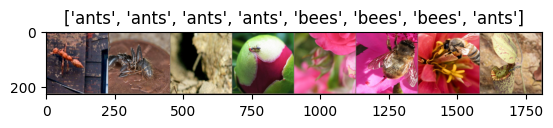

In [11]:
import torchvision
grid = torchvision.utils.make_grid(imgs)
imageshow(grid, text=[classes[c] for c in cls])

In [12]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict()) # 모델의 파라미터 copy
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        # 학습 비학습모드의 설정
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # set model to train mode (i.e. trainbale weights)
            else:
                pretrained_model.eval()   # set model to validation mode

            loss = 0.0
            successes = 0

            # iterate over the (training/validation) data.
            for imgs, tgts in dloaders[dset]:
                imgs = imgs #.to(dvc) # cuda or cpu 로이동
                tgts = tgts # .to(dvc)
                optim.zero_grad()

                # 학습모드 인경우
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

In [13]:
# 추론 과정
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs#.to(dvc)
            tgts = tgts#.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [14]:
model_finetune = models.alexnet(pretrained=True)#.to(dvc)
print(model_finetune.features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [15]:
print(model_finetune.classifier)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [16]:
# train (fine-tune) and validate the model
# change the last layer from 1000 classes to 2 classes
model_finetune.classifier[6] = nn.Linear(4096, len(classes))

loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)

# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.7392288866590281, accuracy in this epoch: 0.5327868852459017
val loss in this epoch: 0.5433974250469332, accuracy in this epoch: 0.7058823529411765

Epoch number 1/9
train loss in this epoch: 0.5581279318840777, accuracy in this epoch: 0.7213114754098361
val loss in this epoch: 0.44979199513890383, accuracy in this epoch: 0.8235294117647058

Epoch number 2/9
train loss in this epoch: 0.4699417996357699, accuracy in this epoch: 0.7868852459016393
val loss in this epoch: 0.394323217810369, accuracy in this epoch: 0.8758169934640523

Epoch number 3/9
train loss in this epoch: 0.4412938721600126, accuracy in this epoch: 0.8073770491803278
val loss in this epoch: 0.361359556710798, accuracy in this epoch: 0.9019607843137255

Epoch number 4/9
train loss in this epoch: 0.4167603166376958, accuracy in this epoch: 0.8114754098360656
val loss in this epoch: 0.3368956738827275, accuracy in this epoch: 0.9084967320261438

Epoch number 5/9
train loss in 

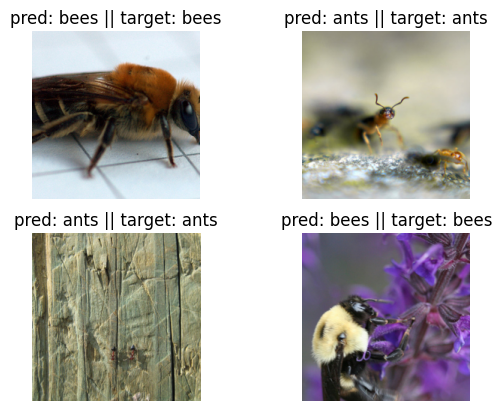

In [17]:
visualize_predictions(model_finetune)


In [18]:
import ast
with open('/content/drive/MyDrive/pytorch_tutoral/실전!파이토치딥러닝프로젝트/dataset/imagenet1000_clsidx_to_labels.txt') as f:
    classes_data = f.read()
classes_dict = ast.literal_eval(classes_data)
print({k: classes_dict[k] for k in list(classes_dict)[:5]})

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


In [19]:
model_finetune = models.vgg(pretrained=True)

TypeError: ignored

In [ ]:
visualize_predictions(model_finetune)
